# Preprocesamiento de datos general

In [47]:
import pandas as pd
import os

url = "C:/Users/USUARIO/Desktop/Proyectos/Sistema_recomendacion/data/raw/data_raw.csv"

if os.path.exists(url):
    data = pd.read_csv(url, sep=',', encoding='latin-1')
    print("Datos cargados exitosamente.", data.shape)
else:
    print("Archivo no encontrado. Verifica la ruta.")

Datos cargados exitosamente. (51290, 24)


## Preprocesamiento

In [48]:
data_clean = data.copy()

### Cambiando tipo de datos

In [49]:
data_clean["Order Date"] = pd.to_datetime(data_clean["Order Date"], format="%d-%m-%Y")
data_clean["Ship Date"] = pd.to_datetime(data_clean["Ship Date"], format="%d-%m-%Y")

### Eliminar columnas

#### Análisis de la columna Postal Code

La columna 'Postal Code' presenta una gran cantidad de valores faltantes. Como se indicó en el análisis exploratorio de datos (EDA), la recomendación inicial es eliminar la columna. Sin embargo, para asegurar una buena decisión, se evalua la variabilidad de esta característica, ya que cuenta aún con '9994' datos no faltantes. Si estos datos corresponen a diferentes clientes, se entrenará y evaluará uno modelo de sistema de recomendación utilizando únicamente los registros de los clientes con esta información. Si por el contrario no aporta información se descartará por completo esta columna.

In [50]:
# Calcular el porcentaje de valores faltantes
missing_values = data_clean.isna().sum()
missing_percentage = (missing_values["Postal Code"] / len(data_clean)) * 100
print(f"El porcentaje de datos faltantes en la columna Postal Code es de {missing_percentage:.2f}%")

El porcentaje de datos faltantes en la columna Postal Code es de 80.51%


In [51]:
postal_notna = data_clean[data_clean["Postal Code"].notna()]
clientes_postal = len(postal_notna["Customer ID"].unique()) / len(data_clean["Customer ID"].unique()) * 100
print("Tamaño de dataset con los valores no faltantes de Postal Code", postal_notna.shape)
print(f"Porcentaje de clientes con código postal {clientes_postal:.2f}%")

Tamaño de dataset con los valores no faltantes de Postal Code (9994, 24)
Porcentaje de clientes con código postal 49.87%


La columna 'Postal Code' tiene una proporción muy alta de datos faltantes de 80.51% y solo alrededor del 50% de los clientes cuentan con código postal, al seleccionar solo los clientes que no tengan datos faltantes en esta columna se pierde más de la mitad de los datos. 
La decisión es eliminar por completo la columna 'Postal Code', ya que no aporta un valor crucial para el análisis. Ya que, se cuenta con información geográfica suficiente mediante las columnas 'Country', 'State' y 'City'.
Como se cuenta con 

Las siguientes columnas sera eliminadas del dataset:

* 'Row ID', 'Order ID'. Ya que, no se consideran útiles para el sistema de recomendación al ser identificadores únicos. 
* 'Customer Name', porque es información personal que no contribuye al análisis de comportamiento de compra.
* 'Ship Date', ya que recomendar productos, con base a la rapidez de entrega o tiempo de envio no hace parte del objetivo del sistema de recomendación.
* 'Order Priority', No se considera que la prioridad de los pedidos afecten la recomendaciones.
* 'Product Name', similar a 'Customer Name'.

In [52]:
data_clean.drop(columns=["Row ID", 
                         "Order ID", 
                         "Postal Code", 
                         "Customer Name", 
                         "Ship Date", 
                         "Order Priority"], 
                inplace=True)

### Conjunto de datos para un sistema de recomendación basado en contenido
El siguiente dataset se construye teniendo como criterio que el sistema de recomendación estará basado en contenido, donde las características que describen los productos son relevantes. Por ende, se eliminaran más columnas, que no son importantes para este enfoque.

In [53]:
data_contenido = data_clean.copy()

In [54]:
data_contenido.drop(columns=["Order Date", 
                             "Ship Mode",
                             "Segment", 
                             "City", 
                             "State", 
                             "Country", 
                             "Market",
                             "Region",
                             "Shipping Cost"], inplace=True)

In [55]:
data_contenido

,Customer ID,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,RH-19495,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845
1,JR-16210,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650
2,CR-12730,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710
3,KM-16375,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400
4,RH-9495,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200
...,...,...,...,...,...,...,...,...,...
51285,KE-16420,OFF-FA-10000746,Office Supplies,Fasteners,"Advantus Thumb Tacks, 12 Pack",65.100,5,0.0,4.5000
51286,ZC-21910,OFF-AP-10002906,Office Supplies,Appliances,Hoover Replacement Belt for Commercial Guardsm...,0.444,1,0.8,-1.1100
51287,LB-16795,OFF-EN-10001219,Office Supplies,Envelopes,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes",22.920,3,0.0,11.2308
51288,RB-19795,OFF-BI-10000806,Office Supplies,Binders,"Acco Index Tab, Economy",13.440,2,0.0,2.4000


## Preprocesamiento de valores atípicos y normalización de los datos

Se aplica la transformación logarítmica a la columna 'Sales' para corregir la asimetría y mejorar la distribución asemejándola a una distribución normal.

Se transforman los datos de la columna 'Profit' con yeo-johnson, ya que hay presencia de valores negativos.

La normalización de las columnas 'Profit, Sales' se realiza con RobustScales, ya que presentan gran cantidad de valores atípicos. Este es un método más robusto frente a valores atípicos extremos ya que utiliza el rango intercuartil en lugar de la media y la desviación estandar.

La columna Discount se encuentra en una rango definido de 0 a 1 sin valores atípicos.

La columna Quantity esta en un rango pequeño de 1 a 14 y no muestra afectación por los valores atípicos, se escala los datos a un rango de 0 a 1 sin distorsionar la distribución.

In [56]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Aplicando transformación logaritmica para mejorar la asimetria (Solo valores positivos)
data_contenido["Sales"] = np.log1p(data_contenido["Sales"])

# Transformando los datos con yeo-johnson, porque hay presencia de valores negativos
scaler = PowerTransformer(method="yeo-johnson")
data_contenido["Profit"] = scaler.fit_transform(data_contenido[["Profit"]])

# Se normalizaran los datos con robustScaler. Debido a que, Sales y Profit presentan una gran cantidad de valores atípicos
robust_scaler = RobustScaler()
data_contenido[["Sales", "Profit"]] = robust_scaler.fit_transform(data_contenido[["Sales", "Profit"]])  

# Estandarizando los datos manteniendo el rango 
scaler_minmax = MinMaxScaler()
data_contenido[["Quantity", "Discount"]] = scaler_minmax.fit_transform(data_contenido[["Quantity", "Discount"]])

In [57]:
data_contenido

,Customer ID,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,RH-19495,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,1.588394,0.461538,0.000000,20.040856
1,JR-16210,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",1.817028,0.615385,0.117647,-8.509783
2,CR-12730,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",1.977748,0.615385,0.117647,24.210559
3,KM-16375,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",1.696984,0.307692,0.117647,-2.993289
4,RH-9495,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",1.686946,0.538462,0.000000,8.092162
...,...,...,...,...,...,...,...,...,...
51285,KE-16420,OFF-FA-10000746,Office Supplies,Fasteners,"Advantus Thumb Tacks, 12 Pack",-0.127346,0.307692,0.000000,-0.129376
51286,ZC-21910,OFF-AP-10002906,Office Supplies,Appliances,Hoover Replacement Belt for Commercial Guardsm...,-1.973253,0.000000,0.941176,-0.283839
51287,LB-16795,OFF-EN-10001219,Office Supplies,Envelopes,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes",-0.618037,0.153846,0.000000,0.054199
51288,RB-19795,OFF-BI-10000806,Office Supplies,Binders,"Acco Index Tab, Economy",-0.861686,0.076923,0.000000,-0.186918


### Verificando la distribución de los datos

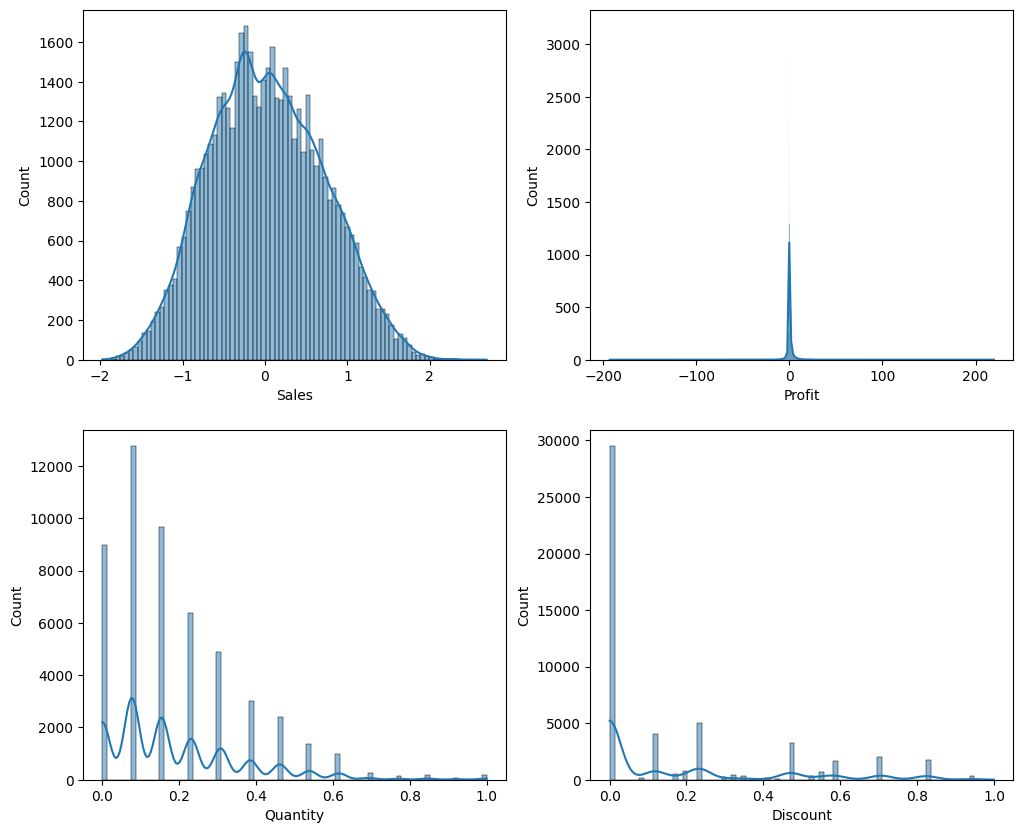

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

rows = 2
cols = 2

# Gráficar las distribuciones de Sales, Profit, Quantity y Discount. 
fig, ax = plt.subplots(rows, cols, figsize=(12, 10))
ax = ax.flatten()

sns.histplot(data_contenido["Sales"], kde=True, ax=ax[0])
sns.histplot(data_contenido["Profit"], kde=True, ax=ax[1])
sns.histplot(data_contenido["Quantity"], kde=True, ax=ax[2])
sns.histplot(data_contenido["Discount"], kde=True, ax=ax[3])

plt.show()

### Verificando los valores atípicos

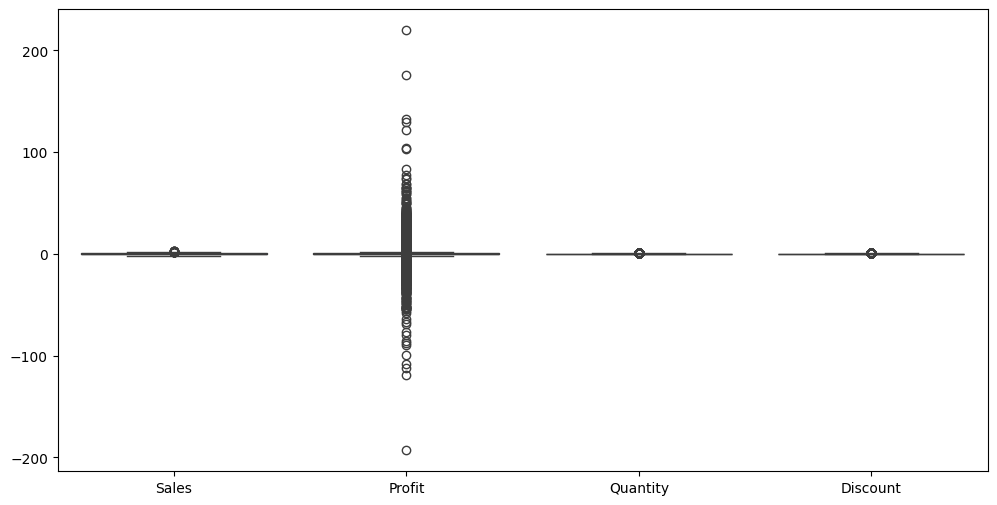

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar boxplots para ver los outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_contenido[["Sales", "Profit", "Quantity", "Discount"]])
plt.show()


### Las estadísticas descriptivas de los datos numéricos

In [229]:
data_contenido.describe()

,Sales,Quantity,Discount,Profit
count,5.129000e+04,51290.000000,51290.000000,51290.000000
mean,2.745797e-02,0.190503,0.168127,0.485706
std,6.873681e-01,0.175290,0.249741,4.768326
min,-1.973253e+00,0.000000,0.000000,-193.058025
25%,-4.812024e-01,0.076923,0.000000,-0.253022
50%,2.143840e-16,0.153846,0.000000,0.000000
75%,5.187976e-01,0.307692,0.235294,0.746978
max,2.690105e+00,1.000000,1.000000,219.745987


#### Codificar variables categóricas nominales
Se codificaran las variables categóricas mediante la técnica BinaryEncoder debidó a la gran cantidad de categorías presentes.

In [231]:
data_contenido.head()

,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,TEC-AC-10003033,Technology,Accessories,1.588394,0.461538,0.000000,20.040856
1,FUR-CH-10003950,Furniture,Chairs,1.817028,0.615385,0.117647,-8.509783
2,TEC-PH-10004664,Technology,Phones,1.977748,0.615385,0.117647,24.210559
3,TEC-PH-10004583,Technology,Phones,1.696984,0.307692,0.117647,-2.993289
4,TEC-SHA-10000501,Technology,Copiers,1.686946,0.538462,0.000000,8.092162


In [232]:
data_contenido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product ID    51290 non-null  object 
 1   Category      51290 non-null  object 
 2   Sub-Category  51290 non-null  object 
 3   Sales         51290 non-null  float64
 4   Quantity      51290 non-null  float64
 5   Discount      51290 non-null  float64
 6   Profit        51290 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.7+ MB


In [58]:
url = "C:/Users/USUARIO/Desktop/Proyectos/Sistema_recomendacion/data/processed/processed_data.csv"
data_contenido.to_csv(url, sep=',', encoding="utf-8", index=False)

In [13]:
import category_encoders as ce

X = data_contenido.drop(columns=["Product ID"])

binary_encoder = ce.BinaryEncoder(cols=["Category", "Sub-Category"])
X = binary_encoder.fit_transform(X)

### Verificando la codificación

In [14]:
X

,Category_0,Category_1,Sub-Category_0,Sub-Category_1,Sub-Category_2,Sub-Category_3,Sub-Category_4,Sales,Quantity,Discount,Profit
0,0,1,0,0,0,0,1,1.588394,0.461538,0.000000,20.040856
1,1,0,0,0,0,1,0,1.817028,0.615385,0.117647,-8.509783
2,0,1,0,0,0,1,1,1.977748,0.615385,0.117647,24.210559
3,0,1,0,0,0,1,1,1.696984,0.307692,0.117647,-2.993289
4,0,1,0,0,1,0,0,1.686946,0.538462,0.000000,8.092162
...,...,...,...,...,...,...,...,...,...,...,...
51285,1,1,1,0,0,0,0,-0.127346,0.307692,0.000000,-0.129376
51286,1,1,0,1,0,0,0,-1.973253,0.000000,0.941176,-0.283839
51287,1,1,0,1,1,1,1,-0.618037,0.153846,0.000000,0.054199
51288,1,1,0,0,1,1,0,-0.861686,0.076923,0.000000,-0.186918


In [255]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, radius=5.0)
nbrs.fit(X)

NearestNeighbors(n_neighbors=10, radius=5.0)

In [259]:
data["Product Name"].iloc[3]

'Motorola Smart Phone, Cordless'

In [263]:
Producto_prueba = X.iloc[3].values
# radius_neighbors devuelve los indices de los vecinos más cercanos al dato de prueba
d, sugerencias = nbrs.radius_neighbors(Producto_prueba.reshape(1, -1), radius=5)
# El valor del radio define el número de vecinos que se considera como similares y si los criterios son amplios o estrictos
# de similitud.

# Mostrar las recomendaciones usando los ids de los productos
for sugerencia in sugerencias[0]:
    print(data.loc[sugerencia, 'Product Name'])

c:\Users\USUARIO\Desktop\Proyectos\Sistema_recomendacion\venv_recomendacion\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Apple Speaker Phone, with Caller ID
Memorex Router, USB
Tenex File Cart, Blue
Motorola Smart Phone, Full Size
Motorola Speaker Phone, VoIP
Cisco Smart Phone, Cordless
Cisco Unified IP Phone 7945G VoIP phone
Enermax Router, Erganomic
Motorola Speaker Phone, Full Size
Lesro Computer Table, Adjustable Height
Konica Card Printer, Red
Harbour Creations Rocking Chair, Adjustable
Nokia Headset, with Caller ID
Smead Lockers, Industrial
Smead Lockers, Wire Frame
O'Sullivan Living Dimensions 3-Shelf Bookcases
HP Copy Machine, High-Speed
Harbour Creations Swivel Stool, Adjustable
Okidata B401 Printer
Canon Wireless Fax, Color
Smead File Cart, Single Width
Belkin Memory Card, USB
Hon Executive Leather Armchair, Black
Bevis Rectangular Conference Tables
Samsung Signal Booster, VoIP
Sharp Ink, Laser
Apple Signal Booster, Cordless
Chromcraft Coffee Table, Fully Assembled
Apple Office Telephone, VoIP
Okidata Printer, Durable
Lesro Coffee Table, Adjustable Height
Lesro Training Table, Fully Assembled
R